## Data Cleaning and Preparation
***

In [786]:
import pandas as pd
import numpy as np
import glob
import re
from bs4 import BeautifulSoup 
import requests
import pickle 
import matplotlib.pyplot as plt
import seaborn as sns

In [787]:
# Load in T100 data from csv files

files_li = glob.glob('zippedData/T_T100D*.2.csv') 
bts_df = pd.DataFrame(pd.read_csv(files_li[0])) 
for i in range(1,len(files_li)): 
    data = pd.read_csv(files_li[i]) 
    df1 = pd.DataFrame(data) 
    bts_df = pd.concat([df1,bts_df],axis=0, ignore_index=True) 

In [788]:
# Keep only top 40 used aircraft models

bts_40 = bts_df['AIRCRAFT_TYPE'].value_counts().head(40).index.to_list()
indexNum = bts_df[~bts_df['AIRCRAFT_TYPE'].isin(bts_40)].index
bts_df.drop(indexNum , inplace=True)

In [789]:
# Get list of top 40 aircraft names for data cleaning

bts_des = pd.DataFrame(pd.unique(bts_df['AIRCRAFT_TYPE']), columns =['AIRCRAFT_TYPE'])

In [790]:
# BTS uses number code to identify aircraft type in it's flight data. The legend is in a seperate csv file. 
# Load in the legend for aircraft type. 

ac_df = pd.read_csv('zippedData/L_AIRCRAFT_TYPE.csv')

In [791]:
# Merge flight data with aircfaft type. This will match BTS type names to the fligt data.

bts_des = pd.merge(bts_des,ac_df,left_on='AIRCRAFT_TYPE',right_on='Code')

In [792]:
# Drop piston aircraft

i = bts_des[(bts_des['Code'] == 40)].index
j = bts_des[(bts_des['Code'] == 35)].index
k = bts_des[(bts_des['Code'] == 194)].index
l = bts_des[(bts_des['Code'] == 79)].index
m = bts_des[(bts_des['Code'] == 479)].index
n = bts_des[(bts_des['Code'] == 415)].index
o = bts_des[(bts_des['Code'] == 416)].index
p = bts_des[(bts_des['Code'] == 412)].index
bts_des = bts_des.drop(i)
bts_des = bts_des.drop(j)
bts_des = bts_des.drop(k)
bts_des = bts_des.drop(l)
bts_des = bts_des.drop(m)
bts_des = bts_des.drop(n)
bts_des = bts_des.drop(o)
bts_des = bts_des.drop(p)

In [793]:
common_words = ['BOEING','CHEROKEE', 'AIRBUS', 'INDUSTRIE', 'CANADAIR', 'EMBRAER', 'MCDONNELL', 'DOUGLAS', 
                'DE', 'HAVILLAND', 'BEAVER', 'SUPER', 'NAVAJO', 'EM', 'ER', 'BEECH']

common_words_eng = ['ILYUSHIN', 'ANTONOV', 'JUNKERS', 'LOCKHEED', 'BOEING','AIRBUS', 'INDUSTRIE', 
                    'CANADAIR', 'EMBRAER', 'STATIONAIR','MCDONNELL', 'DOUGLAS', 'DE', 'HAVILLAND', 'BEAVER',
                    'SUPER','NAVAJO', 'EM', 'ER', 'BEECH', 'CRAFT', 'BOMBARDIER','CANADA']

common_words_emi = ['TRENT', 'CFMI', 'PRATT & WHITNEY', 'GENERAL ELECTRIC', 'CANADA',
                    'ROLLSROYCE', 'LYCOMING', 'ALLISON', 'GARRETT', 'CONTINENTAL', 'IAE']

In [794]:
def short_name(name, x):
    if len(name) >= x:
        short_name = name[:x]
        return(short_name)
    return(name)

In [795]:
def remove_dash(name):
    name = name.replace('-', '')
    return(name)

In [796]:
def convert_upper(name):
    name = name.upper()
    return(name)

In [797]:
def convert_date(date):
    date = date.astype('datetime64[ns]')
    return(date)

In [798]:
def remove_slash(name):
    res = re.match(r"^[^/]*", name)
    return(str(res.group())) 

In [799]:
def remove_common(name, common_w):
    for common in common_w:
        name = name.replace(common, '')
    return(name)

In [800]:
def remove_space(name):
    name = name.replace(' ', "")
    return(name)

In [801]:

def convert_boeing(name):
    if re.match(r"^(7)(.)(7)", name):
        name = name[:3]
    return name

In [802]:
def convert_crj(name):
    if re.match(r"^RJ", name):
        name = name.replace('RJ', 'CRJ')
    return name

In [803]:
# Change Descriptions for data cleaning and matching

bts_des.loc[bts_des['Code'] == 629, 'Description'] = 'Canadair RJ-200'
bts_des.loc[bts_des['Code'] == 631, 'Description'] = 'Canadair RJ-700'
bts_des.loc[bts_des['Code'] == 638, 'Description'] = 'Canadair RJ-900'
bts_des.loc[bts_des['Code'] == 838, 'Description'] = 'Boeing 737-800'
bts_des.loc[bts_des['Code'] == 674, 'Description'] = 'Embraer ERJ-130'
bts_des.loc[bts_des['Code'] == 676, 'Description'] = 'Embraer ERJ-140'
bts_des.loc[bts_des['Code'] == 675, 'Description'] = 'Embraer ERJ-145'
bts_des.loc[bts_des['Code'] == 677, 'Description'] = 'Embraer ERJ-170'
bts_des.loc[bts_des['Code'] == 678, 'Description'] = 'Embraer ERJ-190'

In [804]:
# Change Descriptions for data cleaning and matching

bts_des['Description'] = [convert_upper(x) for x in bts_des['Description']]
bts_des['Description'] = [remove_slash(x) for x in bts_des['Description']]
bts_des['Description'] = [remove_dash(x) for x in bts_des['Description']]
bts_des['Description'] = [remove_common(x, common_words) for x in bts_des['Description']]
bts_des['Description'] = [remove_space(x) for x in bts_des['Description']]
bts_des['Description'] = [short_name(x, 4) for x in bts_des['Description']]
bts_des['Description'] = [convert_boeing(x) for x in bts_des['Description']]
bts_des['Description'] = [convert_crj(x) for x in bts_des['Description']]

In [805]:
# Merge Flight data with cleaned aircraft names

bts_df = pd.merge(bts_df,bts_des[['Code', 'Description']],left_on='AIRCRAFT_TYPE', right_on='Code')

In [806]:
# Drop Code column as we don't need it anymore
bts_des.drop(['AIRCRAFT_TYPE', 'Code'], axis=1, inplace=True)

## Crash Data

In [807]:
# Import Data Set from CSV

crash_df = pd.read_csv('zippedData/AviationData.csv', encoding='latin-1', dtype={6: str, 7: str, 14: str, 15: str,
                                                                                 28: str})

In [808]:
# Drop rows before 2012 so we can match data by year in bts_df
date_mask = (crash_df['Event.Date'] > '2011-12-31')

# THIS RETURNS ALL ROWS GREATER THAN THE DATE PROVIDED ABOVE
crash_df = crash_df.loc[date_mask]

# Rows without an aircraft model type don't help use. Dropping these rows.
crash_df = crash_df.dropna(subset=['Model'])

In [809]:
# Convert Event.Date from string to datetime. Used to filter df on years

crash_df['Event.Date'] = crash_df['Event.Date'].astype('datetime64[ns]')

In [810]:
# Change Model name for data cleaning and matching

crash_df['Model'] = [convert_upper(x) for x in crash_df['Model']]
#crash_df['Event.Date'] = [convert_date(x) for x in crash_df['Event.Date']]
crash_df['Model'] = [remove_slash(x) for x in crash_df['Model']]
crash_df['Model'] = [remove_dash(x) for x in crash_df['Model']]
crash_df['Model'] = [remove_common(x, common_words) for x in crash_df['Model']]
crash_df['Model'] = [remove_space(x) for x in crash_df['Model']]
crash_df['Model'] = [short_name(x, 4) for x in crash_df['Model']]
crash_df['Model'] = [convert_boeing(x) for x in crash_df['Model']]
#crash_df['Model'].replace('PA-', 'PA', inplace=True, regex=True)

In [811]:
# Takes in an aircraft model name and returns the cloest match in bts_des

def match_types(model):
    for newmodel in bts_des['Description']:
        if newmodel.startswith(model):
            #print(f'Processing: {model} \t:{newmodel}')
            return newmodel

In [812]:
# Create new column that matches model name form bts_des

crash_df['NewModel'] = [match_types(model) for model in crash_df['Model']]

## Engine Data

In [813]:
# In place of running this and making lots of web requests, import the pickle file from below
# Assign URL |
#url = "https://asn.flightsafety.org/database/engines/"

# Make a GET request to fetch the raw HTML content 
#html_content = requests.get(url).text 

# Parse the response with html.parser
#soup = BeautifulSoup(html_content,"html.parser") 

# The data we need are wrapped in <a> tags. Grab all the <a> tags here and we'll filter later.
#datas = soup.find_all("a")


#Make list of URLs and list oF Aircraft to create dictionary
# k = []
# v = []
# for item in datas:
#     if 'engine' in item['href']:
#         k.append(item['href'])
#         v.append(item.text)

# lookup_dict = {'URL': k, 'Engine': v}


#url_df = pd.DataFrame.from_dict(lookup_dict)

# with open('lookup_dict.pkl', 'wb') as f:
#     pickle.dump(lookup_dict, f)

with open('zippedData/lookup_dict.pkl', 'rb') as f:
    lookup_dict = pickle.load(f)

In [814]:
# Take in the engine and retriev the matching data page with Aircraft data
# Add Aircraft list from web a python list.
# Return the python list

# url_p1 = 'https://asn.flightsafety.org'
# def lookup_ac(url_p2):
#     return_list = []
#     url = f'{url_p1}{url_p2}'
#     sub_content = requests.get(url).text
#     soup2 = BeautifulSoup(sub_content,"html.parser")
#     u_list=soup2.find_all('ul')[1]
#     i = 0 
#     while i < len(u_list.select('li')):
#         (u_list.select('li')[i].text)
#         return_list.append(u_list.select('li')[i].text)
#         i += 1
#     return(return_list)

# Create Aircraft column to list aircraft for each engine.
#url_df['Aircraft'] = url_df['URL'].map(lookup_ac)

# Save df to pickle file.
#url_df.to_pickle('zippedData/url_df.pkl')

with open('zippedData/url_df.pkl', 'rb') as f:
    url_df = pickle.load(f)

In [815]:
# Create a row for each aircraft for each engine. 
# Iterate through url_df['Aircraft'] column. For each element
# in list, create a new row.

engines = []
aircraft = []
for idx, row in url_df.iterrows():
    for ac in row['Aircraft']:
        engines.append(row['Engine'])
        aircraft.append(ac)

In [816]:
# Create dictionary from lists to load into dataFrame

ac_eng_dict = {'Engine': engines, 'Aircraft': aircraft}

In [817]:
# Create dataFrame from dictionary

engines_df = pd.DataFrame.from_dict(ac_eng_dict)

In [818]:
# Change Name for data cleaning and matching

engines_df.loc[engines_df['Aircraft'] == 'Bombardier CRJ100 / 200 / 440'] = ['General Electric CF34','Canadair RJ-100']
engines_df.loc[engines_df['Aircraft'] == 'Bombardier CRJ700'] = ['General Electric CF34','Canadair RJ-700']
engines_df.loc[engines_df['Aircraft'] == 'Bombardier CRJ900'] = ['General Electric CF34','Canadair RJ-900']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Canadair RJ-200']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Canadair RJ-440']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Embraer ERJ-130']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Embraer ERJ-135']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Embraer ERJ-140']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Embraer ERJ-175']
engines_df.loc[len(engines_df.index)] = ['General Electric CF34', 'Embraer ERJ-190']
engines_df.loc[len(engines_df.index)] = ['Pratt & Whitney JT8D', 'McDonnell Douglas DC-9-80']

In [819]:
# Change Aircraft name for data cleaning and matching

engines_df['Aircraft'] = [convert_upper(x) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [remove_slash(x) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [remove_dash(x) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [remove_common(x, common_words_eng) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [remove_space(x) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [short_name(x, 4) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [convert_boeing(x) for x in engines_df['Aircraft']]
engines_df['Aircraft'] = [convert_crj(x) for x in engines_df['Aircraft']]

In [820]:
# Change Engine name for data cleaning and matching

engines_df['Engine_Name'] = [convert_upper(x) for x in engines_df['Engine']]
engines_df['Engine_Name'] = [remove_slash(x) for x in engines_df['Engine_Name']]
engines_df['Engine_Name'] = [remove_dash(x) for x in engines_df['Engine_Name']]
engines_df['Engine_Name'] = [remove_common(x, common_words_emi) for x in engines_df['Engine_Name']]
engines_df['Engine_Name'] = [remove_common(x, common_words_emi) for x in engines_df['Engine_Name']]
engines_df['Engine_Name'] = [remove_space(x) for x in engines_df['Engine_Name']]
engines_df['Engine_Name'] = [short_name(x, 5) for x in engines_df['Engine_Name']]
#engines_df['Engine_Name'] = [convert_boeing(x) for x in engines_df['Engine_Name']]
#engines_df['Engine_Name'] = [convert_crj(x) for x in engines_df['Engine_Name']]

In [821]:
# Add Engine data to bts_des

bts_des = pd.merge(bts_des, engines_df,left_on='Description', right_on='Aircraft', how='left')
bts_des.drop_duplicates(inplace=True)

## Emissions Data

In [822]:
# Load Engine emissions data

emissions_df = pd.read_excel('zippedData/edb-emissions-databank_v30__web_.xlsx',
                             sheet_name='Gaseous Emissions and Smoke', 
                             usecols=('A:D, AJ'))

In [823]:
# Change Engine name for data cleaning and matching

emissions_df['Engine Identification'] = [convert_upper(x) for x in emissions_df['Engine Identification']]
emissions_df['Engine Identification'] = [remove_slash(x) for x in emissions_df['Engine Identification']]
emissions_df['Engine Identification'] = [remove_dash(x) for x in emissions_df['Engine Identification']]
emissions_df['Engine Identification'] = [remove_common(x, common_words_emi) for x in emissions_df['Engine Identification']]
emissions_df['Engine Identification'] = [remove_space(x) for x in emissions_df['Engine Identification']]
emissions_df['Engine Identification'] = [short_name(x, 5) for x in emissions_df['Engine Identification']]

In [824]:
# Force name change for certain engines

emissions_df.at[527,'Engine Identification'] = 'PW100'
emissions_df.at[611,'Engine Identification'] = 'PW200'
emissions_df.at[633,'Engine Identification'] = 'PW400'

In [825]:
# Takes in an Engine name and returns the CO2 value

def match_engine(str1):
    tmp_df = pd.DataFrame()
    mask = tmp_df['engine_id_starts_with_CFM'] = list( 
        map(lambda x: x.startswith(str1), emissions_df['Engine Identification'])) 
    filtered_df = emissions_df[mask]
    #return(filtered_df.at[0,1]['CO Dp/Foo Avg (g/kN)']).head(1)
    if filtered_df.shape[0] < 1:
        return(0)
    return(filtered_df.iat[0,4])

In [826]:
# Add Co2 data to bts_des

bts_des['Co2'] = [match_engine(x) for x in bts_des['Engine_Name']]

## Data Processing

In [830]:
# Some rows have NaN for values. Replace these with 0 value. 

crash_df['Total.Fatal.Injuries'] = crash_df['Total.Fatal.Injuries'].fillna(0)
crash_df['Total.Serious.Injuries'] = crash_df['Total.Serious.Injuries'].fillna(0)
crash_df['Total.Minor.Injuries'] = crash_df['Total.Minor.Injuries'].fillna(0)

In [831]:
# Our scoring system will use 3 points for fatality; 1 point for serious injury and .5 points for minor injury.

crash_df['Injury_Score'] = crash_df['Total.Fatal.Injuries'].map(lambda x: x*3)
crash_df['Injury_Score'] = crash_df['Injury_Score'] + crash_df['Total.Serious.Injuries']
crash_df['Injury_Score'] = crash_df['Injury_Score'] + (crash_df['Total.Minor.Injuries'] * .5)

In [833]:
# Sum Injury Score and put into new temp df

total_score = crash_df.groupby('NewModel')['Injury_Score'].sum().to_frame()

total_score['Count'] = bts_df.groupby('Description').size()

total_score['Rating'] = (total_score['Injury_Score'] / total_score['Count'])

total_score = pd.merge(total_score, bts_des[['Co2', 'Aircraft', 'Engine']], left_on='NewModel', right_on='Aircraft', how='left')

In [834]:

final_score = total_score.sort_values(['Co2', 'Rating'], ascending=[True, True])

# Drop engines for which data is unavailable
final_score = final_score.loc[final_score['Co2'] > 0]

In [835]:
# Normalize Injury Rating and Co2
co2_max = final_score['Co2'].max()
co2_min = final_score['Co2'].min()
rating_max = final_score['Rating'].max()
rating_min = final_score['Rating'].min()
co2_range = co2_max - co2_min
rating_range = rating_max - rating_min

# normalized_value = (feature_value - feature_min) / (feature_max - feature_min) 

final_score['Co2 Normal'] = [((x - co2_min) / (co2_range) * 100) for x in final_score['Co2']]

final_score['Rating Normal'] = [((x - rating_min) / (rating_range) * 100) for x in final_score['Rating']]

final_score['Combined'] = final_score['Co2 Normal'] + final_score['Rating Normal']

final_sorted = final_score.sort_values(by=['Combined'])

In [862]:
final_sorted

,Injury_Score,Count,Rating,Co2,Aircraft,Engine,Co2 Normal,Rating Normal,Combined
39,1.5,28799,0.000052,14.20,MD11,Pratt & Whitney PW4000,0.000000,0.639119,0.639119
18,6.0,64824,0.000093,14.20,A300,Pratt & Whitney PW4000,0.000000,1.135751,1.135751
20,24.5,213230,0.000115,14.80,A319,IAE V2500,0.313972,1.409891,1.723863
40,2.5,21323,0.000117,14.80,MD90,IAE V2500,0.313972,1.438664,1.752636
10,16.0,178044,0.000090,32.00,757,Pratt & Whitney PW2000,9.314495,1.102708,10.417203
38,1.5,28799,0.000052,34.43,MD11,General Electric CF6,10.586081,0.639119,11.225199
32,6.0,16324,0.000368,27.80,DHC8,Pratt & Whitney Canada PW100,7.116693,4.510165,11.626858
16,6.0,64824,0.000093,34.43,A300,General Electric CF6,10.586081,1.135751,11.721832
14,106.5,98231,0.001084,14.20,767,Pratt & Whitney PW4000,0.000000,13.303590,13.303590
34,0.0,153205,0.000000,43.15,J145,Rolls-Royce AE3007,15.149137,0.000000,15.149137


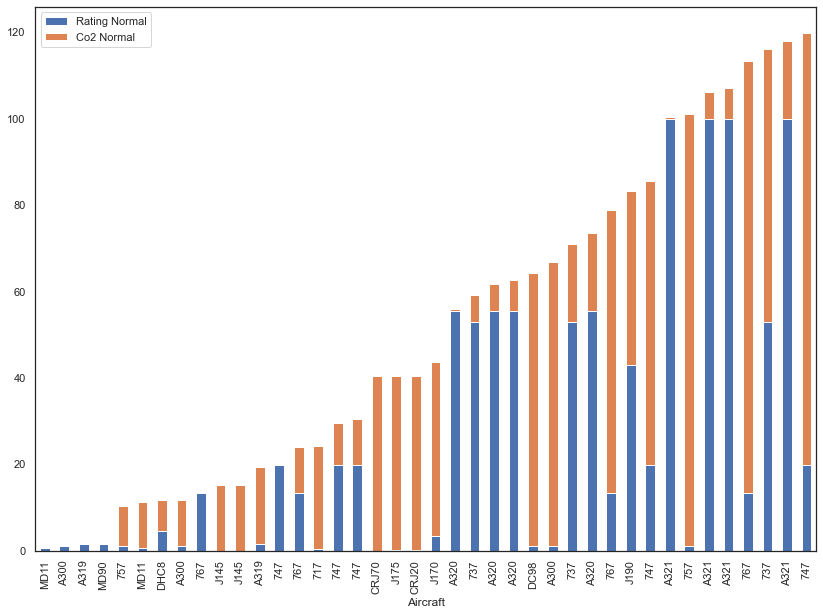

In [861]:
plt.rcParams['figure.figsize'] = [14, 10]
final_sorted.plot(x='Aircraft', y=['Rating Normal', 'Co2 Normal'], kind='bar', stacked=True)

plt.show()


## Airport Data Analysis


In [837]:
# Load Airport data from csv file

ap_df = pd.read_csv('zippedData/us-airports.csv')

In [695]:
# Get Population data from Wikipedia

url = "https://en.wikipedia.org/wiki/List_of_North_American_metropolitan_areas_by_population"

wiki_df = pd.read_html(url)[0]

wiki_df = wiki_df[(wiki_df['Country'] == 'United States')]

In [838]:
# Only keep columns we need. Drop other columns

ap_df = ap_df[['id', 'ident', 'type', 'name', 'local_region', 'municipality','local_code',
               'iata_code', 'keywords']]

ap_df = ap_df[(ap_df['type'] == 'large_airport')]

In [700]:
# Get count of flights originated at airport and convert to dict

ap_counts = bts_df['ORIGIN'].value_counts()
ap_counts_dict = ap_counts.to_dict()


In [839]:
# This takes in an airport code and returns the total number of flights orginating from there

def get_num_flt(code):
    try:
      val = ap_counts_dict[code]
    except:
      val = 0
    
    return val

In [840]:
# Takes in city name and returns population

def get_wiki_pop(city):
    try:
        pop = wiki_df.loc[wiki_df['Metropolitan area'] == city, 'Population'].values[0]
        return pop
    except:
        return(0)

In [843]:
# Create df to combine flight data and population
#apuse_df = ap_df.copy()
#apuse_df['NumFlights'] = [get_num_flt(x) for x in apuse_df['iata_code']]

#ap_mask = (apuse_df['NumFlights'] != 0)
#apuse_df = apuse_df.loc[ap_mask]



In [846]:
# Group city and state airports and sum total flights from multiple airports

result2 = apuse_df.groupby(['municipality', 'local_region'])

# extract keys from groups

keys = result2.groups.keys()

# Add num of flights to city name

city_lst = []
state_lst = []
num_flt_lst = []

for i in keys:
    a_group = result2.get_group(i)
    city_lst.append(a_group['municipality'][:1].to_string(index=False))
    state_lst.append(a_group['local_region'][:1].to_string(index=False))
    num_flt_lst.append(a_group['NumFlights'].sum())
 

In [847]:
# Add population data to result_df

result2_dict = {'City': city_lst, 'State': state_lst, 'NumFlights': num_flt_lst}
result2_df = pd.DataFrame.from_dict(result2_dict)

pop_lst = []
for i, x in result2_df.iterrows():
    pop_lst.append(get_wiki_pop(x['City']))
    
result2_df['Population'] = pop_lst

result2_df = result2_df.loc[result2_df['Population'] > 0]

In [848]:
# Calculate flight per popuation ratio

pfr_lst = []
for i, x in result2_df.iterrows():
    
    ratio = x['Population']/x['NumFlights']
    pfr_lst.append(ratio)
    
result2_df['FPR'] = pfr_lst

In [849]:
result2_df.sort_values('FPR', ascending=False)

,City,State,NumFlights,Population,FPR
46,Portland,ME,6035,2508928,415.729577
35,New York,NY,75408,19563798,259.439290
27,Los Angeles,CA,64172,12870137,200.556894
30,Miami,FL,35830,6139812,171.359531
51,Sacramento,CA,15095,2417259,160.136403
53,San Antonio,TX,20820,2655928,127.566186
5,Boston,MA,38603,4903026,127.011528
12,Columbus,OH,18791,2162066,115.058592
43,Philadelphia,PA,54467,6242746,114.615198
21,Houston,TX,68883,7370464,106.999753
